In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg

In [2]:
train = pd.read_csv('../data/train/train.csv')
sub = pd.read_csv('../data/sample_submission.csv')

## 전처리

##### 가장 가까운 정보(2일 전 데이터)로 미래를 예측

In [3]:
for i in range(0,81):
    s1 = "test_%d = pd.read_csv('../data/test/%d.csv')"%(i,i)
    exec(s1)

In [4]:
for i in range(0, 1093):
    s1 = "train_%d = pd.concat([train.loc[train['Day'] == %d].reset_index(drop = True), train.loc[train['Day'] == %d + 2].reset_index(drop = True).rename(columns = {'TARGET' : 'TARGET_2'})['TARGET_2']], axis = 1)"%(i, i, i)
    exec(s1)

In [5]:
train_x = pd.concat([train_0, train_1], axis = 0).reset_index(drop=True)
train_x.tail()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,TARGET_2
91,1,21,30,0,0,2.2,74.50,-8,0.0,0.0
92,1,22,0,0,0,2.2,72.83,-8,0.0,0.0
93,1,22,30,0,0,2.2,72.82,-8,0.0,0.0
94,1,23,0,0,0,2.2,72.51,-8,0.0,0.0
95,1,23,30,0,0,2.2,72.49,-8,0.0,0.0


In [6]:
for i in range(2, 1093):
    s1 = "train_x = pd.concat([train_x, train_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [7]:
#변수생성
hour_mean = train_x.groupby(['Hour'])['TARGET'].mean()
minute_mean = train_x.groupby(['Minute'])['TARGET'].mean()
train_x['Hour_mean'] = train_x['Hour'].map(hour_mean)
train_x['Minute_mean'] = train_x['Minute'].map(minute_mean)

In [8]:
train_x = train_x.drop(['Day', 'Hour', 'Minute'], axis = 1)
train_x.tail()

,DHI,DNI,WS,RH,T,TARGET,TARGET_2,Hour_mean,Minute_mean
52459,0,0,3.5,55.97,-1,0.0,0.0,0.0,17.799137
52460,0,0,3.9,54.23,-2,0.0,0.0,0.0,17.810955
52461,0,0,4.1,54.21,-2,0.0,0.0,0.0,17.799137
52462,0,0,4.3,56.46,-2,0.0,0.0,0.0,17.810955
52463,0,0,4.1,56.44,-2,0.0,0.0,0.0,17.799137


In [9]:
x_train = train_x.drop(['TARGET_2'], axis = 1)
y_train = train_x['TARGET_2']

In [10]:
for i in range(0, 81):
    s1 = "test_%d = test_%d[240:].reset_index(drop = True)"%(i,i)
    s2 = "hour_mean = test_%d.groupby(['Hour'])['TARGET'].mean()"%(i)
    s3 = "minute_mean = test_%d.groupby(['Minute'])['TARGET'].mean()"%(i)
    s4 = "test_%d['Hour_mean'] = test_%d['Hour'].map(hour_mean)"%(i,i)
    s5 = "test_%d['Minute_mean'] = test_%d['Minute'].map(minute_mean)"%(i,i)
    s6 = "test_%d = test_%d.drop(['Day', 'Hour', 'Minute'], axis = 1)"%(i,i)
    exec(s1)
    exec(s2)
    exec(s3)
    exec(s4)
    exec(s5)
    exec(s6)

In [11]:
test_x = pd.concat([test_0, test_1], axis = 0).reset_index(drop=True)
test_x.tail()

,DHI,DNI,WS,RH,T,TARGET,Hour_mean,Minute_mean
187,0,0,1.7,43.65,-5.2,0.0,0.0,11.308777
188,0,0,1.5,40.62,-4.9,0.0,0.0,11.297040
189,0,0,1.5,40.62,-4.9,0.0,0.0,11.308777
190,0,0,1.5,39.21,-4.9,0.0,0.0,11.297040
191,0,0,1.5,39.50,-5.0,0.0,0.0,11.308777


In [12]:
for i in range(2, 81):
    s1 = "test_x = pd.concat([test_x, test_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [13]:
x_test = test_x.copy()

### 변수선택(best subest)

In [14]:
import math

In [15]:
x_train['GHI'] = x_train['DNI']*math.cos(math.pi/180*63)+x_train['DHI']
x_test['GHI'] = x_test['DNI']*math.cos(math.pi/180*63)+x_test['DHI']
x_train = x_train.drop(['DHI', 'DNI', 'Hour_mean', 'Minute_mean'], axis = 1)
x_test = x_test.drop(['DHI', 'DNI', 'Hour_mean', 'Minute_mean'], axis = 1)

In [16]:
x_train.tail()

,WS,RH,T,TARGET,GHI
52459,3.5,55.97,-1,0.0,0.0
52460,3.9,54.23,-2,0.0,0.0
52461,4.1,54.21,-2,0.0,0.0
52462,4.3,56.46,-2,0.0,0.0
52463,4.1,56.44,-2,0.0,0.0


In [17]:
print(x_train.shape)
print(x_test.shape)

(52464, 5)
(7776, 5)


In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

def linear_reg(X,y):
    model = linear_model.LinearRegression(fit_intercept = True)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

def random_forest(X,y):
    model = RandomForestRegressor(n_estimators=500, max_features=0.25)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

def gradient_boosting(X, y):
    model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500, max_depth=3)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared    

def support_vector(X, y):
    model = SVR(kernel = 'rbf')
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared 

def extraTree(X, y):
    model = ETR_model = ExtraTreesRegressor(n_estimators=1000)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared 

In [18]:
submission = pd.read_csv('../data/sample_submission.csv')
submission.set_index('id',inplace=True)

In [21]:
train_data.shape
x_col

['TARGET']

In [25]:
x_train.head()

,WS,RH,T,TARGET,GHI
0,1.5,69.08,-12,0.0,0.0
1,1.5,69.06,-12,0.0,0.0
2,1.6,71.78,-12,0.0,0.0
3,1.6,71.75,-12,0.0,0.0
4,1.6,75.20,-12,0.0,0.0


In [ ]:
#X변수 개수
m = len(y_train)
k = 5
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#1 ~ 5까지 모든 조합에 대한 성능 테스트(RSS, R_Squared)
for k in tnrange(1,len(x_train.columns) + 1):
    for combo in itertools.combinations(x_train.columns,k):
        tmp_result = extraTree(x_train[list(combo)],y_train)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#결과
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [33]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,3.239942e+07,0.070288,"(WS,)",3.635949e+06,0.895665
1,1,1.692397e+07,0.514361,"(RH,)",3.635949e+06,0.895665
2,1,2.375725e+07,0.318278,"(T,)",3.635949e+06,0.895665
3,1,4.063687e+06,0.883391,"(TARGET,)",3.635949e+06,0.895665
4,1,3.635949e+06,0.895665,"(GHI,)",3.635949e+06,0.895665
5,2,4.134542e+06,0.881358,"(WS, RH)",1.519239e+06,0.956405
6,2,1.972120e+07,0.434094,"(WS, T)",1.519239e+06,0.956405
7,2,1.868174e+06,0.946392,"(WS, TARGET)",1.519239e+06,0.956405
8,2,2.282512e+06,0.934503,"(WS, GHI)",1.519239e+06,0.956405
9,2,4.272156e+06,0.877409,"(RH, T)",1.519239e+06,0.956405


In [34]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_min

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
4,1,3.635949e+06,0.895665,"(GHI,)",3.635949e+06,0.895665
10,2,1.519239e+06,0.956405,"(RH, TARGET)",1.519239e+06,0.956405
23,3,1.174578e+06,0.966295,"(RH, TARGET, GHI)",1.174578e+06,0.966295
29,4,1.104194e+06,0.968315,"(RH, T, TARGET, GHI)",1.104194e+06,0.968315
30,5,1.039427e+06,0.970173,"(WS, RH, T, TARGET, GHI)",1.039427e+06,0.970173


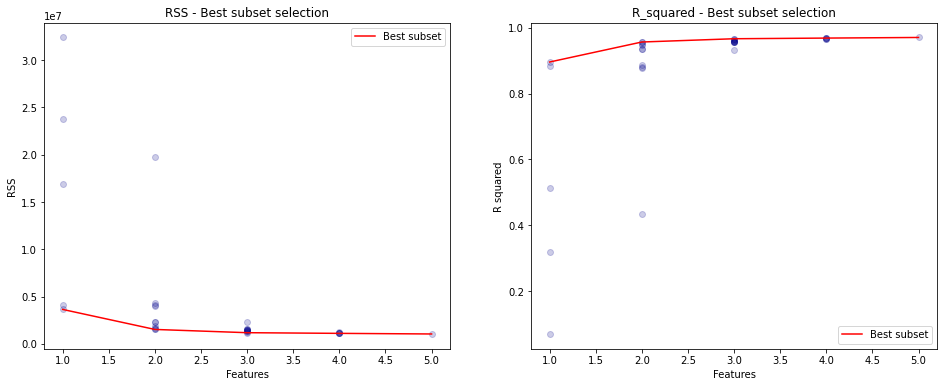

In [35]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

In [32]:
sub['q_0.1'] = QuantReg(y_train, x_train['GHI']).fit(q=0.1).predict(x_test['TARGET'])
sub['q_0.2'] = QuantReg(y_train, x_train['GHI']).fit(q=0.2).predict(x_test['TARGET'])
sub['q_0.3'] = QuantReg(y_train, x_train['GHI']).fit(q=0.3).predict(x_test['TARGET'])
sub['q_0.4'] = QuantReg(y_train, x_train['GHI']).fit(q=0.4).predict(x_test['TARGET'])
sub['q_0.5'] = QuantReg(y_train, x_train['GHI']).fit(q=0.5).predict(x_test['TARGET'])
sub['q_0.6'] = QuantReg(y_train, x_train['GHI']).fit(q=0.6).predict(x_test['TARGET'])
sub['q_0.7'] = QuantReg(y_train, x_train['GHI']).fit(q=0.7).predict(x_test['TARGET'])
sub['q_0.8'] = QuantReg(y_train, x_train['GHI']).fit(q=0.8).predict(x_test['TARGET'])
sub['q_0.9'] = QuantReg(y_train, x_train['GHI']).fit(q=0.9).predict(x_test['TARGET'])

NameError: name 'y_test' is not defined

In [ ]:
sub['q_0.1'] = QuantReg(y_train, x_train['GHI']).fit(q=0.1).predict(x_test['TARGET'])
sub['q_0.2'] = QuantReg(y_train, x_train['GHI']).fit(q=0.2).predict(x_test['TARGET'])
sub['q_0.3'] = QuantReg(y_train, x_train['GHI']).fit(q=0.3).predict(x_test['TARGET'])
sub['q_0.4'] = QuantReg(y_train, x_train['GHI']).fit(q=0.4).predict(x_test['TARGET'])
sub['q_0.5'] = QuantReg(y_train, x_train['GHI']).fit(q=0.5).predict(x_test['TARGET'])
sub['q_0.6'] = QuantReg(y_train, x_train['GHI']).fit(q=0.6).predict(x_test['TARGET'])
sub['q_0.7'] = QuantReg(y_train, x_train['GHI']).fit(q=0.7).predict(x_test['TARGET'])
sub['q_0.8'] = QuantReg(y_train, x_train['GHI']).fit(q=0.8).predict(x_test['TARGET'])
sub['q_0.9'] = QuantReg(y_train, x_train['GHI']).fit(q=0.9).predict(x_test['TARGET'])

In [29]:
sub.to_csv('테스트.csv', index = False)

In [20]:
x_train.describe()

,WS,RH,T,TARGET,GHI
count,52464.000000,52464.000000,52464.000000,52464.000000,52464.000000
mean,2.455596,56.795208,9.297842,17.805046,170.998408
std,1.427477,22.065222,10.179041,25.773161,213.363335
min,0.000000,7.590000,-19.000000,0.000000,0.000000
25%,1.400000,39.667500,1.000000,0.000000,0.000000
50%,2.200000,57.600000,9.000000,0.000000,0.000000
75%,3.200000,72.780000,17.000000,32.096062,387.785268
max,12.000000,100.000000,35.000000,99.913939,700.964276


In [22]:
x_train.tail()

,WS,RH,T,TARGET,GHI
52459,3.5,55.97,-1,0.0,0.0
52460,3.9,54.23,-2,0.0,0.0
52461,4.1,54.21,-2,0.0,0.0
52462,4.3,56.46,-2,0.0,0.0
52463,4.1,56.44,-2,0.0,0.0


In [24]:
y_train.tail()

52459    0.0
52460    0.0
52461    0.0
52462    0.0
52463    0.0
Name: TARGET_2, dtype: float64

In [33]:
x_test.tail()

,WS,RH,T,TARGET,GHI
7771,0.8,63.35,13.7,0.0,0.0
7772,0.7,64.82,13.1,0.0,0.0
7773,0.7,66.10,12.8,0.0,0.0
7774,0.6,67.64,12.4,0.0,0.0
7775,0.6,69.44,12.0,0.0,0.0
